In [1]:
#
# Process-- we are going to first make a script that can convert from a given source DXF into 
# a DXF-AAMA file with just those blocks and entities selected and ordered
#
# Should be able to send these files to the cutter as-is for verification (and potentially their layout)
#
# Subsequent process to pull these files in and reposition them ourselves with a combined new layout
#

In [1]:
# Inputs for converting a single file
inputfilename = "../dxffiles/P-E-13,5-BS-Master-09.dxf"
dmax = 0.2
cutlayers, penlayers = ["BSF-CUT-BOTH"], ['BSF-PLOT-PUMA']
cutlayers, penlayers = ["BSR-CUT-PUMA"], ['BSR-PLOT-PUMA']
#cutlayers, penlayers = ["BSM-CUT-BOTH"], ['BSM-PLOT-PUMA']
#cutlayers, penlayers = ["PATCH-OUTSIDE", "PATCH-INSIDE", "PATCH-MYLAR"], [ ]
outputfilename = "../dxffiles/aamaout/BSR-PUMA.dxf"
#outputfilename = "../dxffiles/aamaout/PATCHES.dxf"

import ezdxf
d = ezdxf.readfile(inputfilename)
print("layerspresent:", set(e.dxf.layer for e in d.entities))

d = ezdxf.readfile(inputfilename)
lwpolylines = [ e  for e in d.entities  if e.dxftype() == "LWPOLYLINE" ]
if lwpolylines:
    print("exploding %d lwpolylines" % len(lwpolylines))
    for e in lwpolylines:
        e.explode()


layerspresent: {'BSF-CUT-BOTH', 'BSR-CUT-EVO', 'BSM-CUT-BOTH', 'BSM-PLOT-EVO', 'BSR-PLOT-PUMA', 'PATCH-OUTSIDE', 'PATCH-MYLAR', 'BSR-CUT-PUMA', 'CONSTRUCTION', 'BSF-PLOT-PUMA', 'BSM-PLOT-PUMA', 'SPLINES-MASTER', 'PATCH-INSIDE', 'BSF-PLOT-EVO', 'PATCH-REF', 'BSR-PLOT-EVO', 'PUMA-REF', 'HISTORY'}
exploding 5 lwpolylines


In [2]:
import ezdxf
from dxfgrouping import filterlayerelements, makemergevertset, linearizeelement

cutelements = filterlayerelements(d, cutlayers)
penelements = filterlayerelements(d, penlayers)


dmaxs-tail:  [0.0837293917808445, 0.19947231855597392, 0.19947231855597392]
suppressing loop making merge
suppressing loop making merge
vertdegs: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 3, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 2, 2]


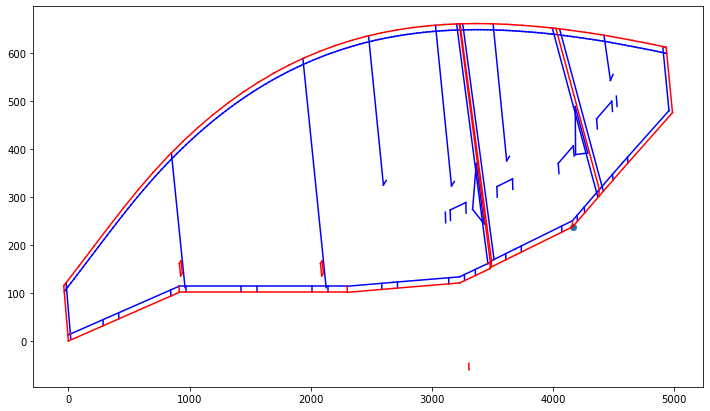

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(12,7))
for es, c in [(penelements, "blue"), (cutelements, "red")]:
    for e in es:
        ps = linearizeelement(e)
        plt.plot([p.x  for p in ps], [p.y  for p in ps], color=c)


smergevertset = makemergevertset(cutelements, 1.2)
def mergeverterror(mv):
    return max((mv.pt - me.pts[0 if me.bfore else -1]).magnitude  for me in mv.mergeedges)
highmergeerrors = [ mv.pt  for mv in smergevertset  if mergeverterror(mv) > 0.1 ]
plt.scatter([pt.x  for pt in highmergeerrors], [pt.y  for pt in highmergeerrors])

dmaxs-tail:  [0.0837293917808445, 0.19947231855597392, 0.19947231855597392]
suppressing loop making merge
suppressing loop making merge
vertdegs: [1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 3, 3, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Component:  36 12 161
dmaxs-tail:  [0.0837293917808445, 0.19947231855597392, 0.19947231855597392]
vertdegs: [2, 1, 2, 3, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2]
Component:  24 3 99
dmaxs-tail:  [0.0]
vertdegs: [1, 1, 2]
Component:  4 0 0


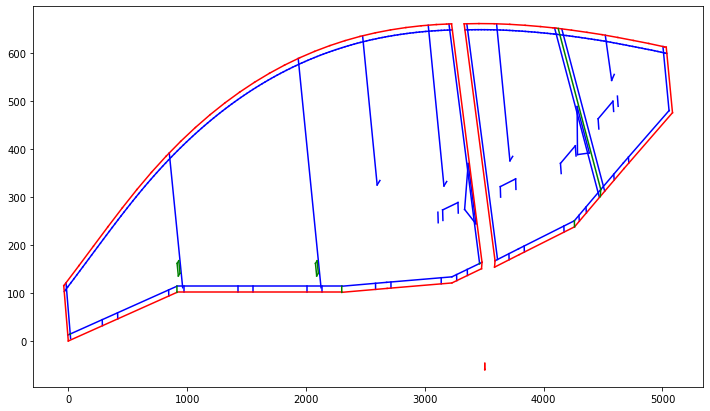

In [4]:
from dxfgrouping import getblockcomponent, dxfoutputblocks

lcutelements, lpenelements = cutelements, penelements
elementgroups = [ ]

while lcutelements:
    res = getblockcomponent(lcutelements, lpenelements, dmax)
    (outercutelements, outercutelementsdir) = res[0]
    (internalcutelements, internalpenelements) = res[1]
    (remainingcutelements, remainingpenelements) = res[2]
    elementgroups.append((outercutelements, outercutelementsdir, internalcutelements, internalpenelements))
    lcutelements, lpenelements = remainingcutelements, remainingpenelements
    print("Component: ", len(outercutelements), len(internalcutelements), len(internalpenelements))
    
plt.figure(figsize=(12,7))
xdisp = 0
for loutercutelements, loutercutelementsdir, linternalcutelements, linternalpenelements in elementgroups:
    for es, c in [(linternalpenelements, "blue"), (loutercutelements, "red"), (linternalcutelements, "green")]:
        for e in es:
            ps = linearizeelement(e)
            plt.plot([p.x+xdisp  for p in ps], [p.y  for p in ps], color=c)
    xdisp += 100

In [5]:

dxfoutputblocks(outputfilename, elementgroups)
